In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

/Users/marcocristo/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
mnist = input_data.read_data_sets('data/MNIST_data')

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print mnist.train.num_examples
print mnist.test.num_examples
print mnist.validation.num_examples

55000
10000
5000


8

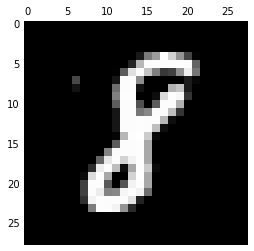

In [17]:
import random

idx = random.randint(0, mnist.train.num_examples)
plt.matshow(mnist.train.images[idx].reshape((28,28)), cmap = 'gray')
mnist.train.labels[idx]

In [36]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        else:
            return ypred
            
class Layer(object):
    """Camada de rede neural sequencial"""
    def __init__(self, units, activation = None, name = None):
        self.units = units
        self.name = name 
        self.activation = activation if activation != None else Activation('')
        
    def output(self, X):
        n_inputs = int(X.get_shape()[1])
        with tf.name_scope(self.name):
            self.W = tf.Variable(self.activation.init(n_inputs, self.units), name = 'W')
            self.b = tf.Variable(tf.zeros([self.units]), name = 'b')
            ypred = self.activation.fire(tf.matmul(X, self.W) + self.b)
        return ypred

class LossFunction(object):
    def __init__(self, name = 'sigmoid'):
        self.name = name

    def get(self, yreal, ypred):
        if self.name == 'sigmoid':
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels = yreal, logits = ypred) 
        return tf.reduce_mean(loss, name = 'lossf')
    
class Optimizer(object):
    def __init__(self, name = 'sgd', lrate = 0.1):
        self.name = name
        self.lrate = lrate

    def get(self, lossf):
        if self.name == 'sgd':
            opt = tf.train.GradientDescentOptimizer(learning_rate = self.lrate) 
        return opt.minimize(lossf)
    
class FeedforwardNeuralNet(object):
    """Rede neural sequencial"""
    def __init__(self, input_dim, lrate = 0.1):
        self.input_dim = input_dim
        self.lrate = lrate
        self.layers = []
        
    def add(self, units, activation = None, name = None):
        """Adiciona camadas para rede neural"""
        self.layers += [Layer(units, activation, name)]
    
    def compile(self, loss = 'sigmoid', optimizer = 'sgd'):
        """Cria grafo da rede neural"""
        self.X = tf.placeholder(tf.float32, 
                           shape = (None, self.input_dim), 
                           name = 'X')
        self.y = tf.placeholder(tf.int64, shape = (None), name = 'y')
        
        # cria layers
        with tf.name_scope('layers'):
            layer_in = self.X
            for layer in self.layers:
                layer_out = layer.output(layer_in)
                layer_in = layer_out
                    
        # loss function
        with tf.name_scope('loss'):
            self.lossf = LossFunction(loss).get(self.y, layer_out)
    
        # optimizer
        with tf.name_scope('train'):
            self.train_op = Optimizer(optimizer, self.lrate).get(self.lossf)
            
        # evalution metrics
        with tf.name_scope('eval'):
            correct = tf.nn.in_top_k(layer_out, self.y, 1)
            self.acc = tf.reduce_mean(tf.cast(correct, tf.float32))
            
        self.init_op = tf.global_variables_initializer()
        self.saver = tf.train.Saver()
    
    def fit(self, train_data, n_epochs, batch_size, val_data = None):
        """Executa treino da rede neural"""
        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b, self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b, self.y: y_b})
                if val_data:
                    acc_val = s.run(self.acc, 
                                    feed_dict = {self.X: val_data.images, 
                                                 self.y: val_data.labels})
                    print '%2d loss: %.8f acct: %.3f accv: %.3f' % (e, 
                                                                    tloss/num_batches, 
                                                                    acc_train, acc_val)
                else:
                    print '%2d loss: %.8f acc: %.3f' % (e, tloss/num_batches, acc_train)
            self.saver.save(s, '/tmp/model.ckpt')
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test, self.y: y_test})
        return acc_test

In [37]:
fnn = FeedforwardNeuralNet(28*28)

fnn.add(units = 300, activation = Activation('sigmoid'), name = 'h1')
fnn.add(units = 100, activation = Activation('sigmoid'), name = 'h2')
fnn.add(units = 10, name = 'out')

fnn.compile()

In [38]:
fnn.fit(mnist.train, n_epochs = 10, batch_size = 50, val_data = mnist.validation)

 0 loss: 0.77025737 acct: 0.860 accv: 0.875
 1 loss: 0.37998930 acct: 0.880 accv: 0.903
 2 loss: 0.30695872 acct: 0.940 accv: 0.914
 3 loss: 0.26576621 acct: 0.920 accv: 0.924
 4 loss: 0.23772365 acct: 0.920 accv: 0.931
 5 loss: 0.21611309 acct: 0.960 accv: 0.934
 6 loss: 0.19817895 acct: 0.940 accv: 0.937
 7 loss: 0.18322160 acct: 0.920 accv: 0.940
 8 loss: 0.17041204 acct: 0.980 accv: 0.941
 9 loss: 0.15935269 acct: 0.980 accv: 0.943


In [39]:
fnn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.93959999

In [27]:
fnn = FeedforwardNeuralNet(28*28)

fnn.add(units = 300, activation = Activation('sigmoid'), name = 'h1')
fnn.add(units = 200, activation = Activation('sigmoid'), name = 'h2')
fnn.add(units = 100, activation = Activation('sigmoid'), name = 'h3')
fnn.add(units = 10, name = 'out')

fnn.compile()

In [28]:
fnn.fit(mnist.train, n_epochs = 10, batch_size = 50)

 0 loss: 0.76557712 acc: 0.86
 1 loss: 0.36817659 acc: 0.92
 2 loss: 0.29207661 acc: 0.94
 3 loss: 0.25025942 acc: 0.92
 4 loss: 0.21961834 acc: 0.98
 5 loss: 0.19711604 acc: 1.00
 6 loss: 0.17888542 acc: 0.98
 7 loss: 0.16398811 acc: 0.98
 8 loss: 0.15184093 acc: 0.98
 9 loss: 0.13996185 acc: 1.00


In [29]:
fnn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.94169998

In [42]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        if self.name == 'sigmoid':
            s = np.sqrt(2. / (n_inputs + n_outputs))
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        elif self.name == 'relu':
            s = 2. / np.sqrt(n_inputs + n_outputs)
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        else:
            return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        if self.name == 'relu':
            return tf.nn.relu(ypred) 
        else:
            return ypred
            

In [43]:
fnn = FeedforwardNeuralNet(28*28)

fnn.add(units = 300, activation = Activation('sigmoid'), name = 'h1')
fnn.add(units = 100, activation = Activation('sigmoid'), name = 'h2')
fnn.add(units = 10, name = 'out')

fnn.compile()

In [44]:
fnn.fit(mnist.train, n_epochs = 10, batch_size = 50, val_data = mnist.validation)

 0 loss: 0.62783600 acct: 0.840 accv: 0.895
 1 loss: 0.33086230 acct: 0.920 accv: 0.916
 2 loss: 0.29454604 acct: 0.960 accv: 0.923
 3 loss: 0.27100554 acct: 0.980 accv: 0.928
 4 loss: 0.25092946 acct: 0.900 accv: 0.934
 5 loss: 0.23226798 acct: 0.900 accv: 0.936
 6 loss: 0.21414431 acct: 0.900 accv: 0.941
 7 loss: 0.19933033 acct: 1.000 accv: 0.946
 8 loss: 0.18506786 acct: 1.000 accv: 0.953
 9 loss: 0.17238688 acct: 0.920 accv: 0.955


In [45]:
fnn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.94910002

In [46]:
fnn = FeedforwardNeuralNet(28*28)

fnn.add(units = 300, activation = Activation('relu'), name = 'h1')
fnn.add(units = 100, activation = Activation('relu'), name = 'h2')
fnn.add(units = 10, name = 'out')

fnn.compile()

In [47]:
fnn.fit(mnist.train, n_epochs = 10, batch_size = 50, val_data = mnist.validation)

 0 loss: 0.24517504 acct: 1.000 accv: 0.967
 1 loss: 0.09659583 acct: 1.000 accv: 0.969
 2 loss: 0.06378422 acct: 1.000 accv: 0.977
 3 loss: 0.04435909 acct: 1.000 accv: 0.981
 4 loss: 0.03208611 acct: 1.000 accv: 0.980
 5 loss: 0.02318602 acct: 1.000 accv: 0.981
 6 loss: 0.01515691 acct: 1.000 accv: 0.980
 7 loss: 0.01097729 acct: 1.000 accv: 0.982
 8 loss: 0.00765493 acct: 1.000 accv: 0.983
 9 loss: 0.00577094 acct: 1.000 accv: 0.982


In [48]:
fnn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.97909999

In [49]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        if self.name == 'sigmoid':
            s = np.sqrt(2. / (n_inputs + n_outputs))
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        elif self.name == 'relu' or self.name == 'elu':
            s = 2. / np.sqrt(n_inputs + n_outputs)
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        else:
            return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        if self.name == 'relu':
            return tf.nn.relu(ypred) 
        if self.name == 'elu':
            return tf.nn.elu(ypred) 
        else:
            return ypred

In [53]:
fnn = FeedforwardNeuralNet(28*28)

fnn.add(units = 300, activation = Activation('elu'), name = 'h1')
fnn.add(units = 100, activation = Activation('elu'), name = 'h2')
fnn.add(units = 10, name = 'out')

fnn.compile()

In [54]:
fnn.fit(mnist.train, n_epochs = 10, batch_size = 50, val_data = mnist.validation)

 0 loss: 0.52349476 acct: 1.000 accv: 0.963
 1 loss: 0.12870802 acct: 1.000 accv: 0.963
 2 loss: 0.09524252 acct: 1.000 accv: 0.975
 3 loss: 0.07248327 acct: 1.000 accv: 0.976
 4 loss: 0.05930154 acct: 1.000 accv: 0.978
 5 loss: 0.04735885 acct: 1.000 accv: 0.976
 6 loss: 0.03949537 acct: 1.000 accv: 0.977
 7 loss: 0.03221011 acct: 1.000 accv: 0.979
 8 loss: 0.02663012 acct: 1.000 accv: 0.981
 9 loss: 0.02204738 acct: 1.000 accv: 0.980


In [55]:
fnn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.9781

In [56]:
class Activation(object):
    """Funcao de ativacao"""
    def __init__(self, name):
        self.name = name
        
    def init(self, n_inputs, n_outputs):
        if self.name == 'selu':
            return tf.truncated_normal([n_inputs, n_outputs], 
                                       stddev = np.sqrt(1./n_inputs))
        elif self.name == 'sigmoid':
            s = np.sqrt(2. / (n_inputs + n_outputs))
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        elif self.name == 'relu' or self.name == 'elu':
            s = 2. / np.sqrt(n_inputs + n_outputs)
            return tf.truncated_normal([n_inputs, n_outputs], stddev = s)
        else:
            return tf.random_uniform([n_inputs, n_outputs], -1.0, 1.0)
        
    def fire(self, ypred):
        def selu(z, scale=1.0507009873554804934193349852946,
                 alpha=1.6732632423543772848170429916717):
            return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))   
        
        if self.name == 'sigmoid':
            return tf.nn.sigmoid(ypred) 
        elif self.name == 'relu':
            return tf.nn.relu(ypred) 
        elif self.name == 'elu':
            return tf.nn.elu(ypred) 
        elif self.name == 'selu':
            return selu(ypred) 
        else:
            return ypred

In [66]:
class SNN (FeedforwardNeuralNet):
    def __init__(self, input_dim, lrate = 0.1):
        FeedforwardNeuralNet.__init__(self, input_dim, lrate)
            
    def fit(self, train_data, n_epochs, batch_size, val_data = None):
        """Executa treino da rede neural"""
        self.means = train_data.images.mean(axis=0, keepdims=True)
        self.stds = train_data.images.std(axis=0, keepdims=True) + 1e-10
        X_val_s = (val_data.images - self.means) / self.stds
        
        num_batches = train_data.num_examples // batch_size
        with tf.Session() as s:
            s.run(self.init_op)
            for e in range(n_epochs):
                tloss = 0.
                for i in range(num_batches):
                    X_b, y_b = train_data.next_batch(batch_size)
                    X_b_s = (X_b - self.means) / self.stds
                    _, loss_e = s.run([self.train_op, self.lossf], 
                                      feed_dict = {self.X: X_b_s, self.y: y_b})
                    tloss += loss_e
                acc_train = s.run(self.acc, 
                                  feed_dict = {self.X: X_b_s, self.y: y_b})
                if val_data:
                    acc_val = s.run(self.acc, 
                                    feed_dict = {self.X: X_val_s, 
                                                 self.y: val_data.labels})
                    print '%2d loss: %.8f acct: %.3f accv: %.3f' % (e, 
                                                                    tloss/num_batches, 
                                                                    acc_train, acc_val)
                else:
                    print '%2d loss: %.8f acc: %.3f' % (e, tloss/num_batches, acc_train)
            self.saver.save(s, '/tmp/model.ckpt')
    
    def evaluate(self, X_test, y_test):
        """Avalia rede neural em colecao de teste"""
        with tf.Session() as s:
            self.saver.restore(s, '/tmp/model.ckpt')
            X_test_s = (X_test - self.means) / self.stds
            acc_test = s.run(self.acc, 
                             feed_dict = {self.X: X_test_s, self.y: y_test})
        return acc_test

In [67]:
snn = SNN(28*28)

snn.add(units = 300, activation = Activation('selu'), name = 'h1')
snn.add(units = 100, activation = Activation('selu'), name = 'h2')
snn.add(units = 10, name = 'out')

snn.compile()

In [69]:
snn.fit(mnist.train, n_epochs = 10, batch_size = 50, val_data = mnist.validation)

 0 loss: 0.91828956 acct: 1.000 accv: 0.953
 1 loss: 0.14386290 acct: 1.000 accv: 0.962
 2 loss: 0.07764883 acct: 1.000 accv: 0.971
 3 loss: 0.04592241 acct: 1.000 accv: 0.971
 4 loss: 0.03387023 acct: 1.000 accv: 0.975
 5 loss: 0.02465808 acct: 1.000 accv: 0.973
 6 loss: 0.01486253 acct: 1.000 accv: 0.973
 7 loss: 0.00968616 acct: 1.000 accv: 0.976
 8 loss: 0.00654101 acct: 1.000 accv: 0.976
 9 loss: 0.00382789 acct: 1.000 accv: 0.977


In [70]:
snn.evaluate(mnist.test.images, mnist.test.labels)

INFO:tensorflow:Restoring parameters from /tmp/model.ckpt


0.97539997